In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
df =pd.read_csv('synthetic_dataset_rules.csv')
print(df)

     Feature1  Feature2  Feature3  Feature4  Label
0    0.374540  0.950714  0.731994  0.598658      4
1    0.156019  0.155995  0.058084  0.866176      0
2    0.601115  0.708073  0.020584  0.969910      3
3    0.832443  0.212339  0.181825  0.183405      4
4    0.304242  0.524756  0.431945  0.291229      2
..        ...       ...       ...       ...    ...
495  0.186101  0.802643  0.458187  0.482969      4
496  0.133480  0.080602  0.727939  0.496461      0
497  0.436851  0.729508  0.765513  0.158908      4
498  0.610225  0.135354  0.751375  0.656955      4
499  0.956615  0.068958  0.057055  0.282187      4

[500 rows x 5 columns]


In [10]:
features = ['Feature1','Feature2','Feature3','Feature4']
X = df[features]
Y = df[['Label']].values

In [11]:
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_scaled = (X - X_min) / (X_max - X_min + 1e-8)

Y_min = Y.min(axis=0)
Y_max = Y.max(axis=0)
Y_scaled = (Y - Y_min) / (Y_max - Y_min + 1e-8)

In [12]:
def train_test_split(X, Y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]

    return X.iloc[train_indices], X.iloc[test_indices], Y[train_indices], Y[test_indices]

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=8)
Y_train_labels = np.argmax(Y_train, axis=1)
Y_test_labels = np.argmax(Y_test, axis=1)

In [13]:
class NeuralNetwork(object):
    def __init__(self):
        inputLayerNeurons = 4
        hiddenLayer1Neurons = 10
        hiddenLayer2Neurons = 8
        hiddenLayer3Neurons = 5
        outLayerNeurons = 4

        self.learning_rate = 0.005
        self.W_HI = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons)
        self.W_HI1 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons)
        self.W_HI2 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons)
        self.W_OH = np.random.randn(hiddenLayer3Neurons, outLayerNeurons)

    def sigmoid(self, x, der=False):
        if der:
            return x * (1 - x)
        else:
            return 1 / (1 + np.exp(-x))

    def feedForward(self, X):
        self.input = X
        self.hidden_input = np.dot(X, self.W_HI)
        self.hidden_output = self.sigmoid(self.hidden_input)

        self.hidden_input1 = np.dot(self.hidden_output, self.W_HI1)
        self.hidden_output1 = self.sigmoid(self.hidden_input1)

        self.hidden_input2 = np.dot(self.hidden_output1, self.W_HI2)
        self.hidden_output2 = self.sigmoid(self.hidden_input2)

        self.output_input = np.dot(self.hidden_output2, self.W_OH)
        self.pred = self.sigmoid(self.output_input)
        return self.pred

    def backPropagation(self, X, Y, pred):
        output_error = Y - pred
        output_delta = output_error * self.sigmoid(pred, True)

        hidden3_error = output_delta.dot(self.W_OH.T)
        hidden3_delta = hidden3_error * self.sigmoid(self.hidden_output2, True)

        hidden2_error = hidden3_delta.dot(self.W_HI2.T)
        hidden2_delta = hidden2_error * self.sigmoid(self.hidden_output1, True)

        hidden1_error = hidden2_delta.dot(self.W_HI1.T)
        hidden1_delta = hidden1_error * self.sigmoid(self.hidden_output, True)


        self.W_OH += self.hidden_output2.T.dot(output_delta) * self.learning_rate
        self.W_HI2 += self.hidden_output1.T.dot(hidden3_delta) * self.learning_rate
        self.W_HI1 += self.hidden_output.T.dot(hidden2_delta) * self.learning_rate
        self.W_HI += X.T.dot(hidden1_delta) * self.learning_rate


    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)

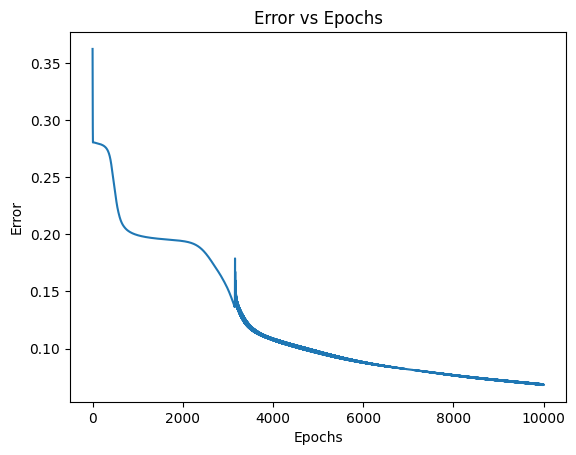

In [14]:
NN = NeuralNetwork()

err = []
for i in range(10000):
  NN.train(X_train, Y_train)
  err.append(np.mean(np.abs(Y_train - NN.feedForward(X_train))))
plt.plot(err)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Error vs Epochs")
plt.show()

In [15]:
def target(pred):
    predicted_class = np.argmax(pred, axis=1)
    target = predicted_class + 1
    return target

predictions = NN.feedForward(X_test)
Y_pred = target(predictions)

print(Y_pred)

[3 2 3 2 2 2 2 2 2 3 2 3 2 3 2 2 4 3 3 2 3 2 2 2 1 2 2 2 2 2 2 2 3 2 3 2 3
 3 3 2 3 3 2 2 2 2 3 3 2 2 2 2 2 3 2 2 3 3 4 2 2 3 2 2 2 2 3 2 2 2 2 3 2 2
 2 2 2 2 2 3 2 2 2 2 1 2 2 3 2 2 2 3 2 2 2 2 2 3 2 4]


In [16]:
def accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    return correct_predictions / total_predictions

Y_test_original = (Y_test * (Y_max - Y_min) + Y_min).astype(int)
Y_test_target = target(Y_test_original)

acc = accuracy(Y_test_target, Y_pred)
print(f"Accuracy: {acc}")

Accuracy: 0.02


In [17]:
predictions_test_probabilities = NN.feedForward(X_test)
predictions_test_labels = np.argmax(predictions_test_probabilities, axis=1)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred, class_label):
    tp = np.sum((y_true == class_label) & (y_pred == class_label))
    fp = np.sum((y_true != class_label) & (y_pred == class_label))
    return tp / (tp + fp + 1e-8)

def recall(y_true, y_pred, class_label):
    tp = np.sum((y_true == class_label) & (y_pred == class_label))
    fn = np.sum((y_true == class_label) & (y_pred != class_label))
    return tp / (tp + fn + 1e-8)

def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-8)

overall_accuracy = accuracy(Y_test_labels, predictions_test_labels)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

for i in range(4):
    prec = precision(Y_test_labels, predictions_test_labels, i)
    rec = recall(Y_test_labels, predictions_test_labels, i)
    f1 = f1_score(prec, rec)
    print(f"Class {i+1}:")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")
    print(f"  F1-Score: {f1:.4f}")

Overall Accuracy: 0.0200
Class 1:
  Precision: 1.0000
  Recall: 0.0200
  F1-Score: 0.0392
Class 2:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
Class 3:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
Class 4:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000


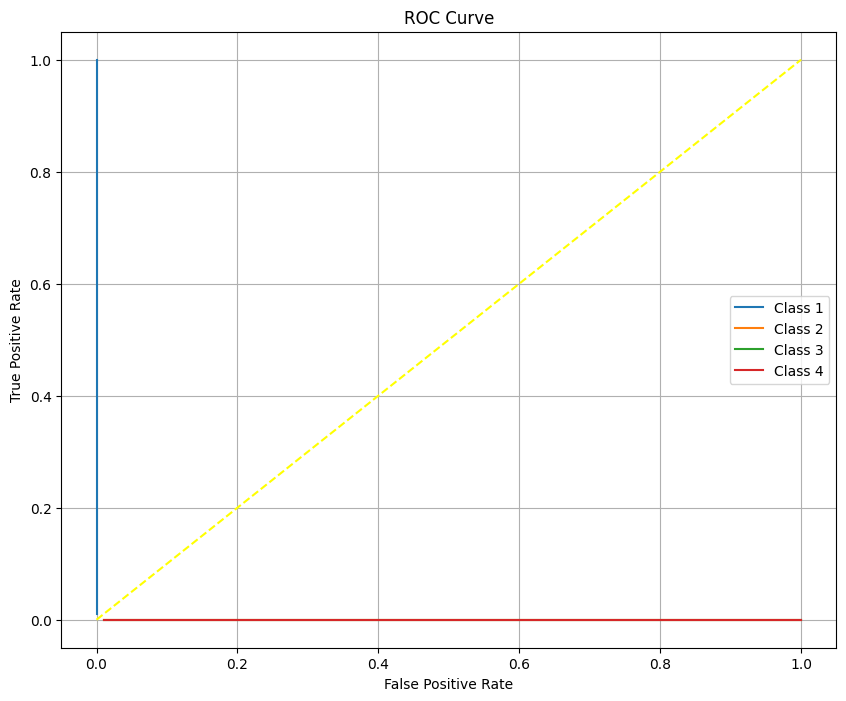

In [25]:
def roc_curve_per_class(y_true, y_scores, num_classes):
    if y_true.shape[1] == 1:
        y_true_onehot = np.zeros((y_true.shape[0], num_classes))
        for i, val in enumerate(y_true.flatten()):
            y_true_onehot[i, int(val)] = 1
        y_true = y_true_onehot

    fpr_all = []
    tpr_all = []
    for class_idx in range(num_classes):
        fpr = []
        tpr = []
        thresholds = sorted(np.unique(y_scores[:, class_idx]), reverse=True)
        for threshold in thresholds:
            y_pred = (y_scores[:, class_idx] >= threshold).astype(int)
            tp = np.sum((y_true[:, class_idx] == 1) & (y_pred == 1))
            fp = np.sum((y_true[:, class_idx] == 0) & (y_pred == 1))
            tn = np.sum((y_true[:, class_idx] == 0) & (y_pred == 0))
            fn = np.sum((y_true[:, class_idx] == 1) & (y_pred == 0))

            if (tp + fn) == 0:
                tpr_val = 0
            else:
                tpr_val = tp / (tp + fn)

            if (fp + tn) == 0:
                fpr_val = 0
            else:
                fpr_val = fp / (fp + tn)
            fpr.append(fpr_val)
            tpr.append(tpr_val)
        fpr_all.append(fpr)
        tpr_all.append(tpr)

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr_all[i], tpr_all[i], label=f'Class {i + 1}')

    plt.plot([0, 1], [0, 1], linestyle='--', color='yellow')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    return fpr_all, tpr_all

fpr_all, tpr_all = roc_curve_per_class(Y_test, predictions, 4)

# New Section